## Applications of Machine Learning in Remote Sensing
### Homework 2

### Nakul Poudel - np1140@rit.edu
https://github.com/np1140/MLRemoteSensing

## Problem 1

In [1]:
import spectral as spy
import spectral.io.envi as envi
import numpy as np
import re
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import StandardScaler


In [2]:
data = spy.envi.open('tait_labsphere.hdr', 'tait_labsphere') # data loading
print(data) 
print(data.shape) # (rows, cols, bands)

	Data Source:   './tait_labsphere'
	# Rows:           1039
	# Samples:        1087
	# Bands:           272
	Interleave:        BSQ
	Quantization:  32 bits
	Data format:   float32
(1039, 1087, 272)


In [3]:
wavelengths = np.array([
    float(re.search(r"\(([\d.]+) nm", name).group(1))
    for name in data.metadata["band names"]
])

# print(wavelengths)   # list all the wavelengths
print(f"Max Wavelength: {wavelengths.max()}, Min Wavelength:{wavelengths.min()}")  # max and min wavelength
#  Find  band indices
blue_band  = np.argmin(abs(wavelengths - 450))
green_band = np.argmin(abs(wavelengths - 550))
red_band   = np.argmin(abs(wavelengths - 650))
nir_band = np.argmin(abs(wavelengths - 850))
print(f"Bands indices; Blue:{blue_band}, Green: {green_band}, Red: {red_band}, Nir: {nir_band}")

Max Wavelength: 1001.81, Min Wavelength:398.573
Bands indices; Blue:23, Green: 68, Red: 113, Nir: 203


## Select blue, green, red bands

In [4]:
# Extract bands
blue = data.read_band(blue_band)
green = data.read_band(green_band)
red = data.read_band(red_band)
nir =  data.read_band(nir_band)

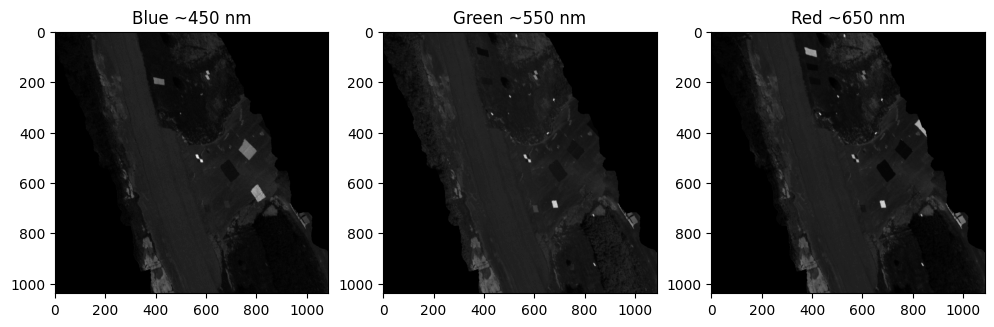

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(blue, cmap='gray'); axs[0].set_title("Blue ~450 nm")
axs[1].imshow(green, cmap='gray'); axs[1].set_title("Green ~550 nm")
axs[2].imshow(red, cmap='gray'); axs[2].set_title("Red ~650 nm")
plt.show()


(np.float64(-0.5), np.float64(1086.5), np.float64(1038.5), np.float64(-0.5))

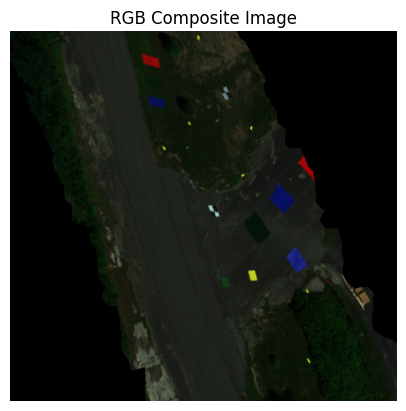

In [6]:
rgb= np.dstack((red, green, blue))
rgb_norm = rgb / np.max(rgb)  # Normalize to [0, 1], max normalization
plt.imshow(rgb_norm)
plt.title("RGB Composite Image")
plt.axis('off')

## Create pseudocolor BGR (using G, R, NIR)

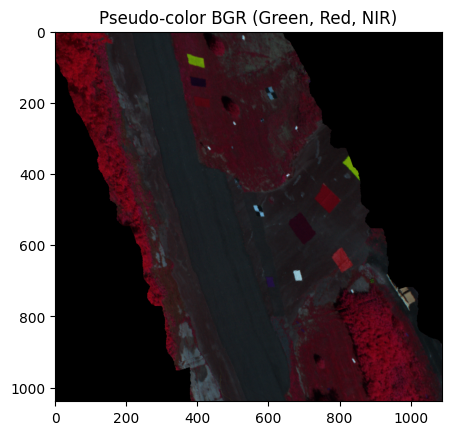

In [7]:
pseudo_bgr = np.dstack((
    data.read_band(nir_band),   #red - > nir
    data.read_band(red_band),   #green - > red
    data.read_band(green_band)  # blue - > green
    ))
pseudo_bgr = pseudo_bgr.astype(float)
pseudo_bgr /= pseudo_bgr.max()

plt.imshow(pseudo_bgr)
plt.title("Pseudo-color BGR (Green, Red, NIR)")
plt.show()

In the pseudo-color image, the red channel is assigned to NIR values. The strong red appearance of vegetation indicates that vegetation reflects significantly more NIR than green wavelengths (seen in the plot above). Similarly, blue objects also appear red, leading to the conclusion that they reflect more strongly in the NIR region as well.

### Plot bands at 900, 950, 1000 nm

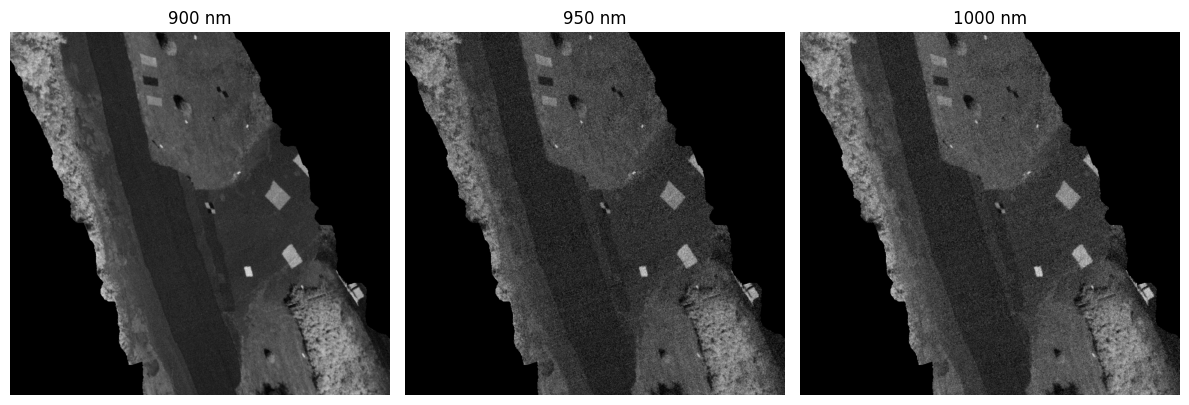

In [8]:
wls = [900, 950, 1000]

fig, axs = plt.subplots(1, len(wls), figsize=(12, 5)) 

for i, wl in enumerate(wls):
    band = np.argmin(abs(wavelengths - wl))
    axs[i].imshow(data.read_band(band), cmap='gray')
    axs[i].set_title(f"{wl} nm")
    axs[i].axis('off') 

plt.tight_layout()

In these plots, the objects are more distinctly visible compared to the visible range.

### Display the correlation matrix as an image

In [9]:
data = data.load() 
h, w, b = data.shape
X = data.reshape(-1, b)   # shape = (h*w, b)
mask = np.any(X > 0, axis=1) # Mask no-data pixels
X_mask = X[mask]  # keep only valid pixels
corr_matrix = np.corrcoef(X_mask, rowvar=False)  # correlation across bands
print(corr_matrix.shape)  # (272, 272)

(272, 272)


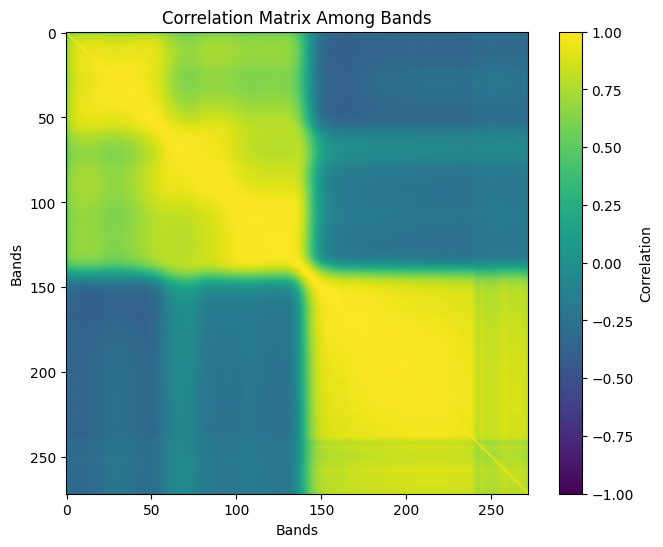

In [10]:
plt.figure(figsize=(8, 6))
plt.imshow(corr_matrix, cmap='viridis', vmin=-1, vmax=1)
plt.colorbar(label="Correlation")
plt.title("Correlation Matrix Among Bands")
plt.xlabel("Bands")
plt.ylabel("Bands")
plt.show()

We observe that bands 0–150 and 150–272 exhibit high intra-group correlation. This is likely because hyperspectral sensors capture data at very fine wavelength intervals, causing adjacent bands to appear nearly identical.

# Problem 2: Principal Component Analysis (PCA)

In [ ]:
def principal_component_analysis(X):
    # Standardize the data
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    X_std = (X - mean) / std
    # Compute SVD
    U, S, Vt = np.linalg.svd(X_std, full_matrices=False)
    pcs = Vt.T   
    m = X_std.shape[0]
    eigenvalues = (S**2) / (m - 1)
    return pcs, eigenvalues, X_std


In [12]:
pcs, eigenvalues, X_std = principal_component_analysis(X)
print(f"PCs shape: {pcs.shape}, Eigenvalues shape: {eigenvalues.shape}")

PCs shape: (272, 272), Eigenvalues shape: (272,)


In [ ]:
h, w, f = data.shape

K = 10  
top_pcs = pcs[:, :K]  

# Project standardized data to top 10 PCs
X_reduced = np.dot(X_std, top_pcs)  

# Reshape
pca_top10_images = X_reduced.reshape(h, w, K)


In [14]:
pca_top10_images.shape

(1039, 1087, 10)

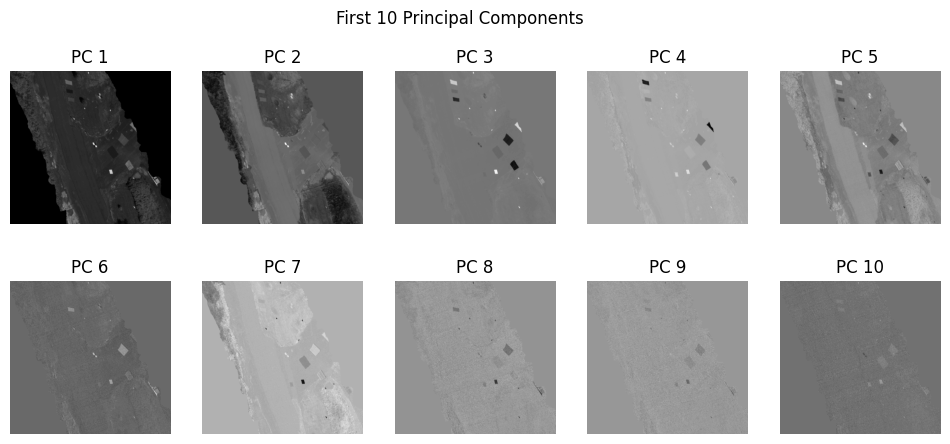

In [15]:
fig, axs = plt.subplots(2, 5, figsize=(12, 5)) 
for i in range(K):
    ax = axs[i//5, i%5]
    im = ax.imshow(pca_top10_images[:, :, i], cmap='gray')
    ax.set_title(f"PC {i+1}")
    ax.axis('off')
plt.suptitle("First 10 Principal Components")
plt.show()


The first principal components (PCs) capture the largest variance, highlighting the main regions such as areas with no data, regions with data, and various objects. The second PC differentiates between vegetation and road. PCs 3, 4, and 5 capture objects of different colors. The last five PCs represent progressively smaller variations, with PCs 8–10 contributing very little additional information.

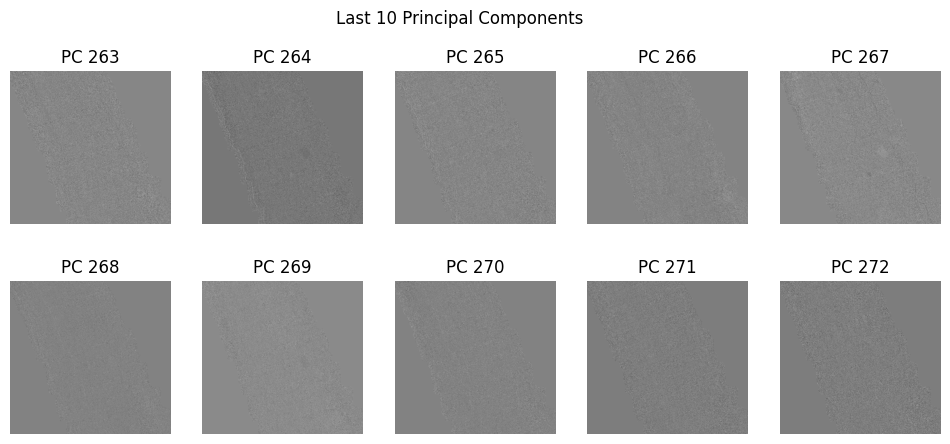

In [16]:
last_pcs = pcs[:, -10:]  
X_last10 = np.dot(X_std, last_pcs)  
pca_last10_images = X_last10.reshape(h, w, 10)

fig, axs = plt.subplots(2, 5, figsize=(12, 5))
for i in range(10):
    ax = axs[i//5, i%5]
    im = ax.imshow(pca_last10_images[:, :, i], cmap='gray')
    ax.set_title(f"PC {f-10+i+1}")  
    ax.axis('off')
plt.suptitle("Last 10 Principal Components")
plt.show()


The last PCs do not highlight any meaningful features in the image and can be considered as primarily representing noise.

### Error visualization for a selected number of principal components (1, 10, 50, 100)

In [17]:
def reconstruct_pca(X_std, pcs, K):
    top_pcs = pcs[:, :K]                 # K principal components
    X_reduced = X_std @ top_pcs  # Project data to K PCs
    X_reconstructed = np.dot(X_reduced, top_pcs.T)  # Reconstruct data
    return X_reconstructed 

In [18]:
pc_list = [1, 10, 50, 100, 272]  # selected number of PCs
errors = []

for K in pc_list:
    X_rec = reconstruct_pca(X_std, pcs, K)
    
    error = np.linalg.norm(X_std - X_rec, axis=1)  # L2 per pixel
    mean_error = error.mean()
    errors.append(mean_error)
    print(f"PCs={K}, Mean reconstruction L2 error: {mean_error:.4f}")


PCs=1, Mean reconstruction L2 error: 6.4400
PCs=10, Mean reconstruction L2 error: 1.7872
PCs=50, Mean reconstruction L2 error: 1.0302
PCs=100, Mean reconstruction L2 error: 0.6965
PCs=272, Mean reconstruction L2 error: 0.0000


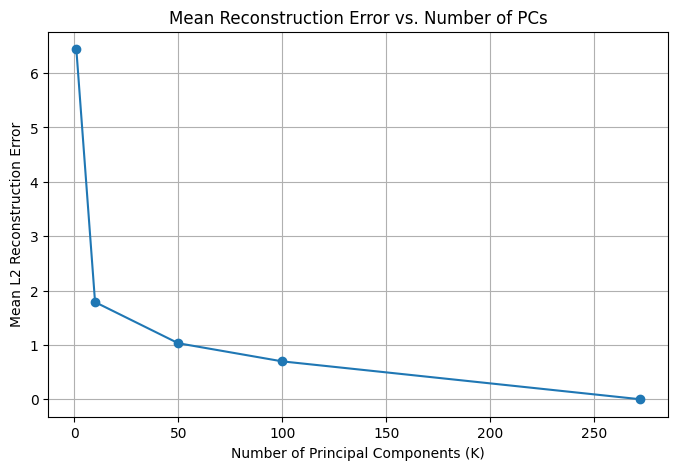

In [19]:
plt.figure(figsize=(8, 5))
plt.plot(pc_list, errors, marker='o')
plt.title("Mean Reconstruction Error vs. Number of PCs")
plt.xlabel("Number of Principal Components (K)")
plt.ylabel("Mean L2 Reconstruction Error")
plt.grid(True)
plt.show()


The reconstruction error is high when only one principal component is used. As more PCs are included, the reconstruction error gradually decreases. When all 272 PCs are used, the reconstruction error becomes zero, as all the information is incorporated; however, using fewer PCs omits certain details.


In [20]:
explained_var_ratio = eigenvalues / eigenvalues.sum()
cumulative_var = np.cumsum(explained_var_ratio)
K = np.argmax(cumulative_var >= 0.99) + 1
print(f"Number of PCs explaining ≥99% variance: {K}")

Number of PCs explaining ≥99% variance: 36


In [21]:
X_pc = np.dot(X_std, pcs)
X_mean = X_mask.mean(axis=0)
X_pc_cpy1 = X_pc.copy()
# K= 1
# Zero out contributions after K
X_pc_cpy1[:, K:] = 0

# Backward transform
X_reconstructed = np.dot(X_pc_cpy1, pcs.T) + X_mean
X_reconstructed = X_reconstructed.reshape(h, w, f)

In [22]:
X_reconstructed.shape

(1039, 1087, 272)

In [23]:
import plotly.express as px
fig = px.imshow(
    rgb_norm,
    title="Normalized RGB Image"  
)
fig.update_layout(
    width=800,
    height=500,
    dragmode=False  
)
fig.show()

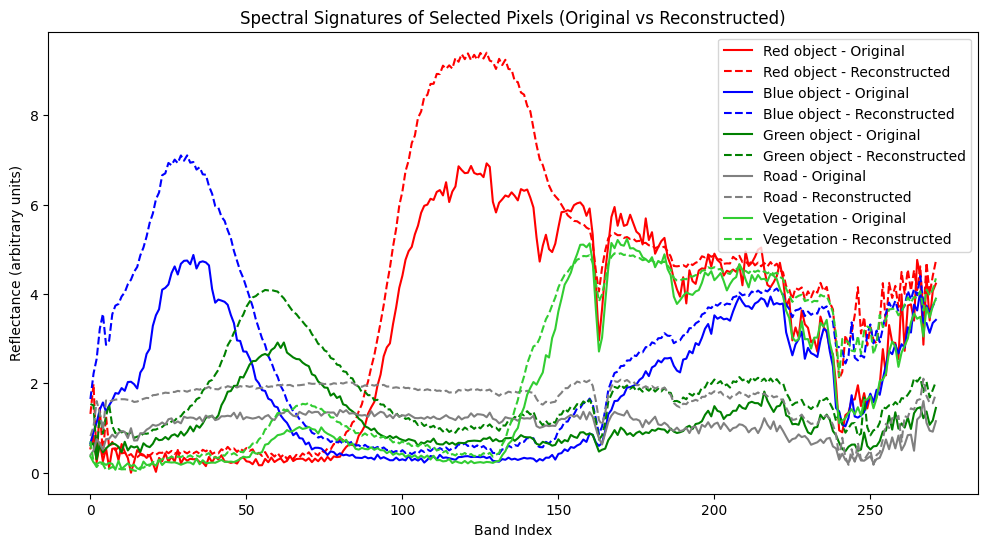

In [24]:
five_interesting_pixels = {                       
    "Red object": (370, 825),
    "Blue object": (467, 767),
    "Green object": (704, 608),
    "Road": (594, 423),
    "Vegetation": (909, 949),
}

# Assign fixed colors
pixel_colors = {
    "Red object": "red",
    "Blue object": "blue",
    "Green object": "green",
    "Road": "gray",
    "Vegetation": "limegreen",
}

plt.figure(figsize=(12, 6))

for label, (r, c) in five_interesting_pixels.items():
    orig_spectrum = np.array(data[r, c, :])        # original
    recon_spectrum = X_reconstructed[r, c, :]     # reconstructed

    color = pixel_colors[label]
    plt.plot(orig_spectrum[0][0], color=color, label=f"{label} - Original")
    plt.plot(recon_spectrum, "--", color=color, label=f"{label} - Reconstructed")

plt.title("Spectral Signatures of Selected Pixels (Original vs Reconstructed)")
plt.xlabel("Band Index")
plt.ylabel("Reflectance (arbitrary units)")
plt.legend()
plt.show()



When utilizing all the PC that represent 99% varaibility in total, the spectral signatures of five different pixels representing various objests closely resembles to that of original data spectral signature. 

### SNR of Original and Reconstructed Signals

In [25]:
data = data.load()
data_array = np.array(data)

data_array[data_array == 0] = np.nan

mu = np.nanmean(data_array)     # mean per band
sigma = np.nanstd(data_array)   # std per band
SNR_org = mu / sigma

print("Mean SNR (original):", SNR_org)

Mean SNR (original): 1.5260783


In [26]:
X_reconstructed = X_reconstructed.astype(np.float32)
valid_reconstructed = X_reconstructed
valid_reconstructed[valid_reconstructed == 0] = np.nan
mu_rec = np.nanmean(valid_reconstructed)
sigma_rec = np.nanstd(valid_reconstructed)
snr_per_band_rec = mu_rec / sigma_rec
SNR_rec = snr_per_band_rec.mean()
print("Mean SNR (reconstructed):", SNR_rec)
improvement = SNR_rec / SNR_org
print(f"SNR Improvement factor: {improvement:.2f}x")

Mean SNR (reconstructed): 1.1749474
SNR Improvement factor: 0.77x


### Impact plot

In [27]:
data = spy.envi.open('tait_labsphere.hdr', 'tait_labsphere') # data loading
data  = data.load()
h, w, f = data.shape
print(data.shape)

(1039, 1087, 272)


In [ ]:
X = data.reshape(-1, f) 

mask = np.any(X != 0, axis=1)
X_valid = X[mask]

scaler = StandardScaler()
X_std = scaler.fit_transform(X_valid)  # (num_valid_pixels, 272)

X_std.shape

(729978, 272)

In [ ]:
pcs, eigenvalues, X_std = principal_component_analysis(X_valid)

In [ ]:
num_pcs = 5
impacts = []

for i in range(num_pcs):
    pc = pcs[:, i]                  # PC  
    ev = eigenvalues[i]             # Eigenvalue
    impact = 2 * np.sqrt(ev) * pc   # Scale by 2*sqrt(eigenvalue), reflect the two-sigma limit
    impacts.append(impact)

impacts = np.array(impacts)
print("Impacts shape:", impacts.shape)  # (5, 272)


Impacts shape: (5, 272)


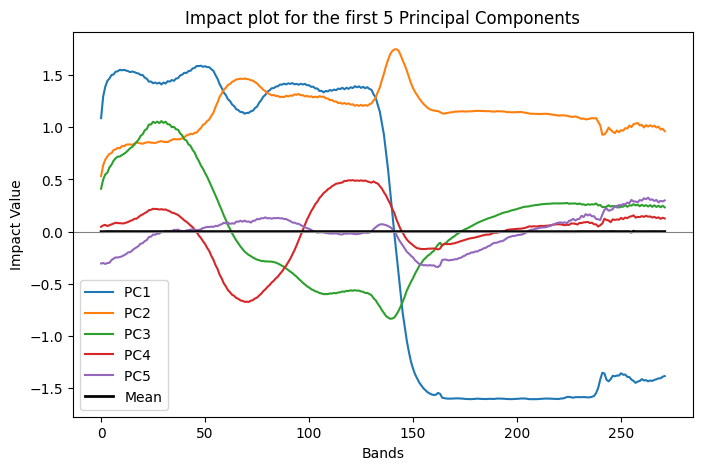

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

mean_features = X_std.mean(axis=0) 

features = np.arange(X_std.shape[1])

# Plot mean and impacts for the first 5 PCs
plt.figure(figsize=(8, 5))

for i in range(5):
    impact =  impacts[i]  
    plt.plot(features, impact, label=f'PC{i+1} ')


plt.plot(features, mean_features, color='black', linewidth=2, label='Mean')

plt.xlabel("Bands")
plt.ylabel("Impact Value")
plt.title("Impact plot for the first 5 Principal Components")
plt.axhline(0, color='gray', linewidth=0.8)
plt.legend()
plt.show()


The impact plot for the first five principal components illustrates how each component influences the spectral bands. PC1 shows a strong positive impact on the first ~150 bands and a negative impact on the remaining bands, indicating a contrast between the lower and higher wavelength regions. PC2 is nearly flat across all bands, suggesting it captures minor uniform variation rather than specific spectral differences. PC3 primarily affects bands 0–165, highlighting variability in the lower-to-mid wavelength range, while PC4 exhibits significant impact on bands 50–150, reflecting localized spectral variability within this region. PC5 shows minimal impact across all bands, contributing little to the overall spectral variance. Overall, these observations indicate that the first few principal components capture the most meaningful spectral variations, with PC1 dominating global contrast and subsequent PCs highlighting finer, localized differences.

### Problem 3: K-Means Clustering

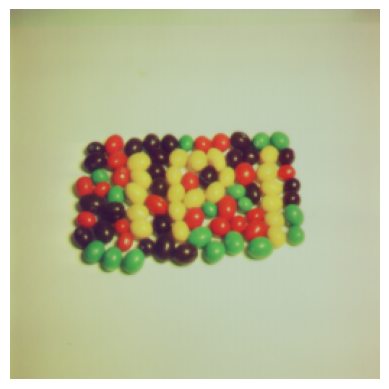

In [ ]:
img = Image.open("jellybeans.tiff") # Load TIFF image
plt.imshow(img)
plt.axis("off") 
plt.show()

In [ ]:
def kmeans(X, K, max_iters=100, tol=1e-4, seed=42):
    np.random.seed(seed)

    # Initialize cluster centers randomly
    rand_indices = np.random.choice(X.shape[0], K, replace=False)
    centroids = X[rand_indices]

    for i in range(max_iters):
        # Assign points to nearest centroid
        distances = np.linalg.norm(X[:, None] - centroids[None, :], axis=2)
        labels = np.argmin(distances, axis=1)

        # Compute new centroids
        new_centroids = np.array([X[labels == k].mean(axis=0) for k in range(K)])

        # Check convergence criteria
        if np.linalg.norm(new_centroids - centroids) < tol:
            print(f"Converged at iteration {i}")
            break
        centroids = new_centroids

    return labels, centroids


In [ ]:
data = np.array(img)  # shape: (H, W, 3)

# Reshape
X = data.reshape(-1, 3).astype(np.float64)

# Standardize 
X_std = (X - X.mean(axis=0)) / X.std(axis=0)

Converged at iteration 54


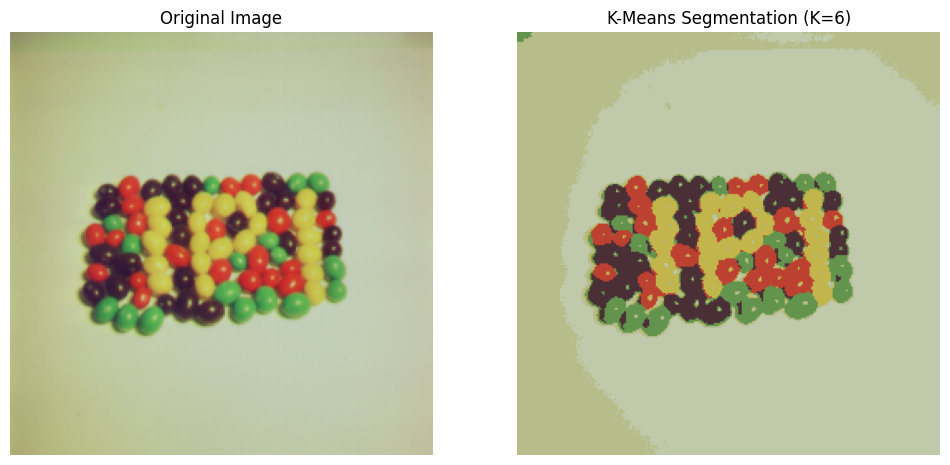

In [ ]:
K = 6 # adjusted based on colors in an image
labels, centroids = kmeans(X_std, K)

# Map labels back to image space using original color scale
segmented = centroids[labels].reshape(data.shape)
# Undo standardization
segmented = (segmented * X.std(axis=0) + X.mean(axis=0)).astype(np.uint8)

# Display original and clustered image
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(img)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title(f"K-Means Segmentation (K={K})")
plt.imshow(segmented)
plt.axis("off")

plt.show()

Experimentally it is determined that K =6 works well for jellybeans image.

### Problem 3(b)

In [ ]:
sentinal_data = np.load("sentinel2_rochester.npy")
rows, cols, bands = sentinal_data.shape  # (rows, cols, bands)
X = sentinal_data.reshape(-1, bands)
mask = np.any(X != 0, axis=1)   # Avoid no data pixels
X_valid = X[mask]

print("Original pixels:", X.shape[0])
print("Valid pixels:", X_valid.shape[0])

Original pixels: 683064
Valid pixels: 630024


In [ ]:
pcs, eigenvalues, X_std = principal_component_analysis(X_valid)

In [ ]:
pc_representations = {}
for k in [3, 4, 5, 6]:
    # Selecting the first k principal components
    top_pcs = pcs[:, :k]  # (bands, k)
    
    # Project the data
    X_reduced = np.dot(X_std, top_pcs)  # (N_samples, k)
    
    # Store for later use
    pc_representations[k] = X_reduced

    print(f"Shape with {k} PCs:", X_reduced.shape)


Shape with 3 PCs: (630024, 3)
Shape with 4 PCs: (630024, 4)
Shape with 5 PCs: (630024, 5)
Shape with 6 PCs: (630024, 6)


In [ ]:
cluster_results = {}

for k in [3, 4, 5, 6]:
    X_reduced = pc_representations[k]  # (rows*cols, k)
    X_reduced_standard = (X_reduced - X_reduced.mean(axis=0)) / X_reduced.std(axis=0)
    # number of clusters 
    K = 5  
    
    labels, centroids = kmeans(X_reduced_standard, K)
    full_labels = np.full(X.shape[0], -1, dtype=int)
    full_labels[mask] = labels
    cluster_results[k] = full_labels.reshape(rows, cols)

    print(f"K-Means done for {k} PCs -> output shape {cluster_results[k].shape}")


Converged at iteration 36
K-Means done for 3 PCs -> output shape (954, 716)
Converged at iteration 49
K-Means done for 4 PCs -> output shape (954, 716)
K-Means done for 5 PCs -> output shape (954, 716)
Converged at iteration 57
K-Means done for 6 PCs -> output shape (954, 716)


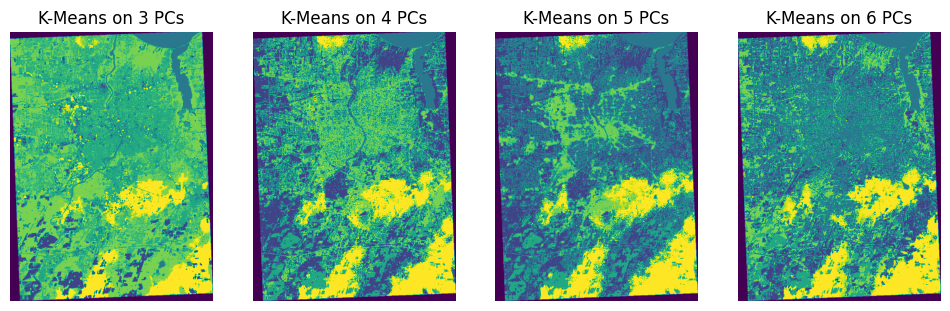

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(12, 4))

for idx, k in enumerate([3, 4, 5, 6]):
    axes[idx].imshow(cluster_results[k])
    axes[idx].set_title(f"K-Means on {k} PCs")
    axes[idx].axis("off")

plt.show()

Here, we found that instead of manually selecting relevant features, the earlier PCs that capture high variability can be used to transform the data into a lower-dimensional representation, enabling effective clustering.

### problem 3(c)

/tmp/ipykernel_105721/1400234148.py:11: DeprecationWarning:

__array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)



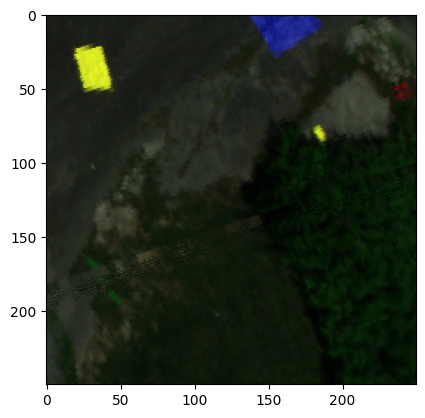

In [ ]:
data = spy.envi.open('tait_labsphere.hdr', 'tait_labsphere') # data loading
data = data.load()
data_patch = data[650:900, 650:900, :]

rgb_bands = [red_band, green_band, blue_band] 


# Extract RGB bands
rgb_data_patch = data_patch[:, :, rgb_bands]

rgb_data_patch_norm = (rgb_data_patch - np.min(rgb_data_patch)) / (np.max(rgb_data_patch) - np.min(rgb_data_patch))

plt.imshow(rgb_data_patch_norm)

In [ ]:
rows, cols, bands = data_patch.shape
X_data_patch = data_patch.reshape(-1, bands)
pcs, eigenvalues, X_std = principal_component_analysis(X_data_patch)

In [ ]:
pc_representations = {}
for k in [2, 5, 10, 50, 100]:
    top_pcs = pcs[:, :k]
    X_reduced = np.dot(X_std, top_pcs)  # (N_valid, k)
    pc_representations[k] = X_reduced


In [ ]:
cluster_results = {}

K = 6 # number of clusters 


for k in [2, 5, 10, 50, 100]:
    X_reduced = pc_representations[k]
    X_reduced_standard = (X_reduced - X_reduced.mean(axis=0)) / X_reduced.std(axis=0)
    labels, centroids = kmeans(X_reduced_standard, K)

    cluster_results[k] = labels.reshape(rows, cols)

    print(f"K-Means done for {k} PCs -> output shape {cluster_results[k].shape}")

Converged at iteration 16
K-Means done for 2 PCs -> output shape (250, 250)
Converged at iteration 41
K-Means done for 5 PCs -> output shape (250, 250)
Converged at iteration 49
K-Means done for 10 PCs -> output shape (250, 250)
Converged at iteration 63
K-Means done for 50 PCs -> output shape (250, 250)
Converged at iteration 35
K-Means done for 100 PCs -> output shape (250, 250)


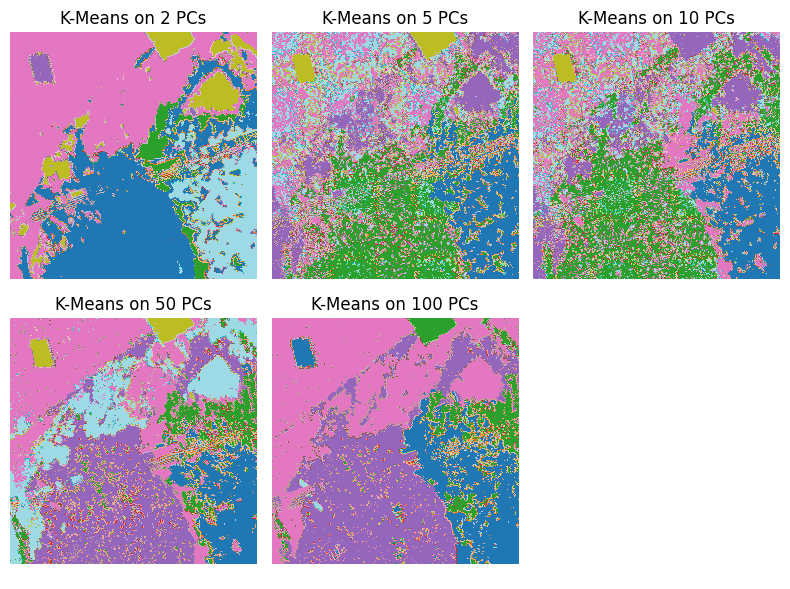

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(8, 6))

# Flatten axes 
axes = axes.ravel()

for idx, k in enumerate([2, 5, 10, 50, 100]):
    axes[idx].imshow(cluster_results[k], cmap="tab20")
    axes[idx].set_title(f"K-Means on {k} PCs")
    axes[idx].axis("off")

axes[-1].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
labels, centroids = kmeans(X_std, K)

cluster_patch = labels.reshape(rows, cols)

print(f"K-Means done for {k} PCs -> output shape {cluster_patch.shape}")

Converged at iteration 20
K-Means done for 100 PCs -> output shape (250, 250)


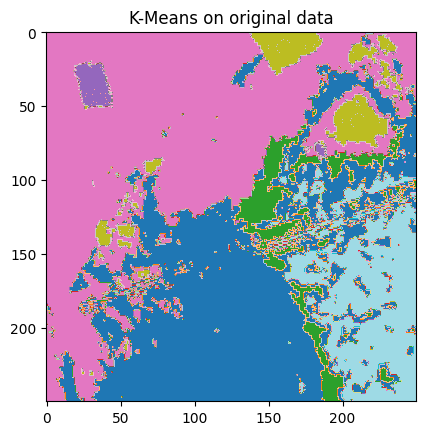

In [ ]:
plt.imshow(cluster_patch, cmap='tab20')
plt.title("K-Means on original data")
plt.show()

We observe that good clusters can be formed using fewer principal components rather than relying on the full-dimensional data. This reduces the computational burden associated with calculating Euclidean distances in the k-means algorithm. We also observe that as more PCs are included, increasingly subtle features are distinguished, which may act as noise and provide limited benefit.